# Importing Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display 
from tqdm import tqdm
import IPython
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPool1D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PolynomialDecay
from tensorflow.keras.callbacks import ModelCheckpoint

# Create the dataset and understand the format

In [ ]:
crema_path = '../input/speech-emotion-recognition-en/Crema'

In [ ]:
emotion_dict = {
    'SAD' : 'sad',
    'ANG' : 'angry',
    'DIS' : 'disgust',
    'FEA' : 'fear',
    'HAP' : 'happy',
    'NEU' : 'neutral',
    
    '04' : 'sad',
    '05' : 'angry',
    '07' : 'disgust',
    '08' : 'surprise',
    '06' : 'fear',
    '03' : 'happy',
    '01' : 'neutral',
    '02' : 'neutral',
    
    'sa' : 'sad',
    'a' : 'angry',
    'd' : 'disgust',
    'su' : 'surprise',
    'f' : 'fear',
    'h' : 'happy',
    'n' : 'neutral'
}

In [ ]:
data = {'file_path': [], 'emotion': []}

for wav in tqdm(os.listdir(crema_path)):
    wav_name = wav.partition(".wav")[0].split("_")
    data['file_path'].append(crema_path+'/'+wav)
    data['emotion'].append(emotion_dict[wav_name[2]])

df = pd.DataFrame(data)
df.head()

100%|██████████| 7442/7442 [00:00<00:00, 490477.85it/s]


,file_path,emotion
0,../input/speech-emotion-recognition-en/Crema/1...,disgust
1,../input/speech-emotion-recognition-en/Crema/1...,happy
2,../input/speech-emotion-recognition-en/Crema/1...,happy
3,../input/speech-emotion-recognition-en/Crema/1...,disgust
4,../input/speech-emotion-recognition-en/Crema/1...,disgust


## Data Augmentation

In [ ]:
def add_noise(data, random=False, rate=0.035, threshold=0.075):
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate * np.random.uniform() * np.amax(data)
    augmented_data = data + noise_amp * np.random.normal(size=data.shape[0])
    return augmented_data

In [ ]:
def pitch(data, sr, pitch_factor=0.7, random=False):
    if random:
        pitch_factor = np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=pitch_factor)

### Implementing 1D features (zcr and rmse)

In [ ]:
def get_1D_features(frame_length=2048, hop_length=512, n_mfcc = 40):
    zcr = []
    rmse = []
    for path, label in tqdm(zip(df['file_path'], df['emotion'])):
        
        y, sr = librosa.load(path)
        
        zcrW = librosa.feature.zero_crossing_rate(y=y, frame_length=frame_length, hop_length=hop_length)
        zcr.append(np.squeeze(zcrW))
        rmseW = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)
        rmse.append(np.squeeze(rmseW))

        noised_data = add_noise(y, random=True)
        zcrW = librosa.feature.zero_crossing_rate(y=noised_data, frame_length=frame_length, hop_length=hop_length)
        zcr.append(np.squeeze(zcrW))
        rmseW = librosa.feature.rms(y=noised_data, frame_length=frame_length, hop_length=hop_length)
        rmse.append(np.squeeze(rmseW))

        pitched_data = pitch(y, sr, random=True)
        zcrW = librosa.feature.zero_crossing_rate(y=pitched_data, frame_length=frame_length, hop_length=hop_length)
        zcr.append(np.squeeze(zcrW))
        rmseW = librosa.feature.rms(y=pitched_data, frame_length=frame_length, hop_length=hop_length)
        rmse.append(np.squeeze(rmseW))
        
        noised_pitched_data = add_noise(pitched_data, random=True)
        zcrW = librosa.feature.zero_crossing_rate(y=noised_pitched_data, frame_length=frame_length, hop_length=hop_length)
        zcr.append(np.squeeze(zcrW))
        rmseW = librosa.feature.rms(y=noised_pitched_data, frame_length=frame_length, hop_length=hop_length)
        rmse.append(np.squeeze(rmseW))
        
    return zcr, rmse

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### 1D model Archeitecture

In [ ]:
def getModel1D(input_shape):
    model = Sequential()
    model.add(Conv1D(512, kernel_size=5, strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

    model.add(Conv1D(512, kernel_size=5, strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

    model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

    model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=3, strides=2, padding="same"))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(6, activation="softmax"))
    return model

### Prepare data

In [ ]:
zcr, rmse = get_1D_features()
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 200

zcr_padded = pad_sequences(zcr, maxlen=max_len, dtype='float32', padding='post', truncating='post', value=0.0)
rmse_padded = pad_sequences(rmse, maxlen=max_len, dtype='float32', padding='post', truncating='post', value=0.0)

7442it [09:56, 12.48it/s]


In [ ]:
npzcr = np.array(zcr_padded)
nprmse = np.array(rmse_padded)

### Train test split

In [ ]:
emotions = df['emotion'].repeat(4)
x = np.hstack([zcr_padded, rmse_padded])
le = LabelEncoder()
emotions = le.fit_transform(emotions)
emotions = to_categorical(emotions, len(np.unique(emotions)))
x_train, x_test, y_train, y_test = train_test_split(x, emotions, random_state=42, test_size=0.3)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((20837, 400), (8931, 400), (20837, 6), (8931, 6))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, test_size=0.05, shuffle=True)

In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size=64)

280/280 [==============================] - 3s 10ms/step - loss: 1.8295 - acc: 0.7368 - f1_m: 0.7373
Accuracy on test data :  73.6759603023529 %


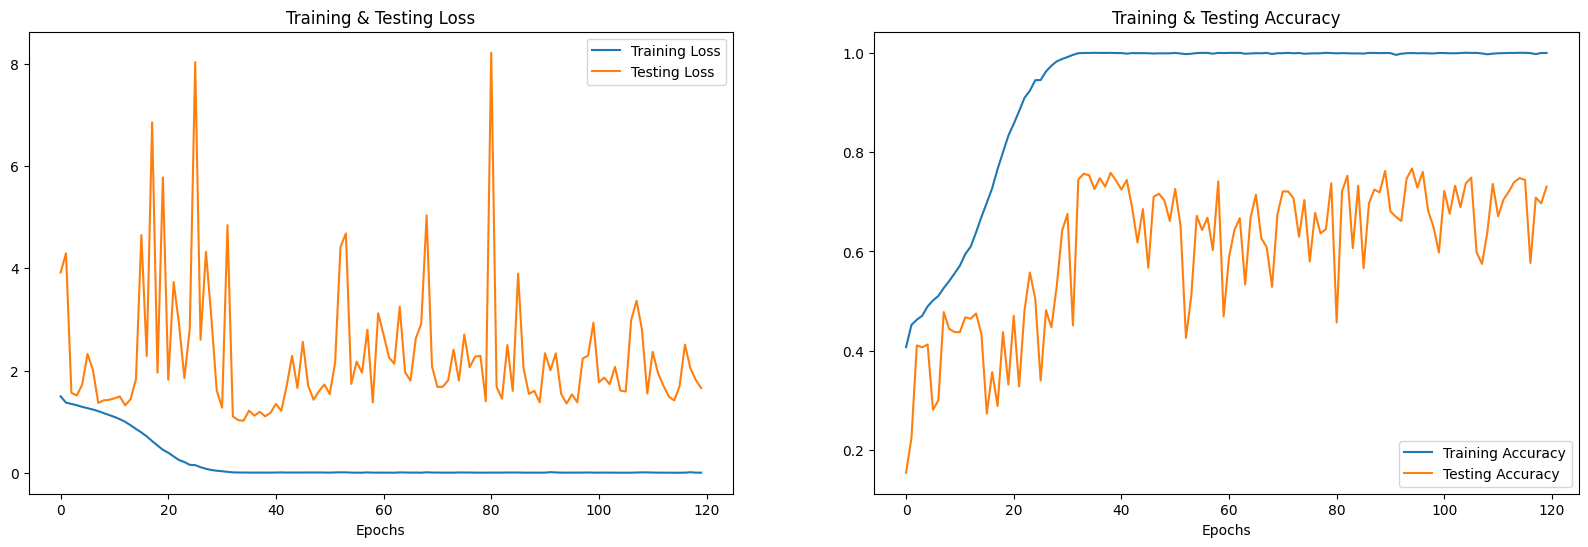

280/280 [==============================] - 3s 9ms/step
8931
8931
0.7367596013884223
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1522
           1       0.68      0.74      0.71      1513
           2       0.62      0.76      0.68      1591
           3       0.81      0.64      0.72      1514
           4       0.75      0.83      0.79      1310
           5       0.77      0.61      0.68      1481

    accuracy                           0.74      8931
   macro avg       0.75      0.74      0.74      8931
weighted avg       0.75      0.74      0.74      8931



In [ ]:
# evaluate the model
# test_loss, test_acc = model.evaluate(x_test, y_test)
# print('Test loss:', test_loss)
# print('Test accuracy:', test_acc)


print("Accuracy on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


model.evaluate(test_dataset)
predA = np.argmax(model.predict(x_test), axis=-1)
y_testc = np.argmax(y_test, axis=-1)

print(len(x_test))
print(len(y_test))
print(accuracy_score(y_testc, predA))
print(classification_report(y_testc, predA))

# create 1D features

In [ ]:
def get_1D_features(frame_length=2048, hop_length=512, n_mfcc = 40):
    zcr = []
    rmse = []
    sr_list = []
    for path, label in tqdm(zip(df['file_path'], df['emotion'])):
        
        y, sr = librosa.load(path)
        sr_list.append(sr)
        zcrW = librosa.feature.zero_crossing_rate(y=y, frame_length=frame_length, hop_length=hop_length)
        zcr.append(np.squeeze(zcrW))
        rmseW = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)
        rmse.append(np.squeeze(rmseW))
    return zcr, rmse, sr_list

In [ ]:
zcr, rmse, sr_list = get_1D_features()
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 200

zcr_padded = pad_sequences(zcr, maxlen=max_len, dtype='float32', padding='post', truncating='post', value=0.0)
rmse_padded = pad_sequences(rmse, maxlen=max_len, dtype='float32', padding='post', truncating='post', value=0.0)

7442it [01:22, 90.71it/s]


In [ ]:
npzcr = np.array(zcr_padded)
nprmse = np.array(rmse_padded)

In [ ]:
emotions = df['emotion']
x = np.hstack([zcr_padded, rmse_padded])
le = LabelEncoder()
emotions = le.fit_transform(emotions)
emotions = to_categorical(emotions, len(np.unique(emotions)))
x_train, x_test, y_train, y_test = train_test_split(x, emotions, random_state=42, test_size=0.3)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5209, 400), (2233, 400), (5209, 6), (2233, 6))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, test_size=0.05, shuffle=True)

In [ ]:
# Data Augmentation
def apply_data_augmentation(frame_length=2048, hop_length=512, n_mfcc=40):
    X = x_train.tolist()
    y = y_train.tolist()
    for i in range(x_train.shape[0]):
        noised_data = add_noise(x_train[i], random=True)        
        X.append(noised_data)
        y.append(y_train[i])

        pitched_data = pitch(x_train[i], sr_list[i], random=True)        
        X.append(pitched_data)
        y.append(y_train[i])
        
        noised_pitched_data = add_noise(pitched_data, random=True)        
        X.append(noised_pitched_data)
        y.append(y_train[i])    
    return X, y

In [ ]:
x_train, y_train = apply_data_augmentation()

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=400
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=400
  warnings.warn(


In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size=64)

In [ ]:
y_train = np.array(y_train)

# 1D modeling

Epoch 1/50
309/310 [============================>.] - ETA: 0s - loss: 1.6034 - acc: 0.3739 - f1_m: 0.2542
Epoch 1: val_f1_m improved from -inf to 0.19937, saving model to best_model_kaggle.h5
310/310 [==============================] - 25s 64ms/step - loss: 1.6031 - acc: 0.3741 - f1_m: 0.2550 - val_loss: 3.5347 - val_acc: 0.1992 - val_f1_m: 0.1994
Epoch 2/50
309/310 [============================>.] - ETA: 0s - loss: 1.4133 - acc: 0.4298 - f1_m: 0.2995
Epoch 2: val_f1_m improved from 0.19937 to 0.19990, saving model to best_model_kaggle.h5
310/310 [==============================] - 19s 61ms/step - loss: 1.4130 - acc: 0.4300 - f1_m: 0.3004 - val_loss: 1.9076 - val_acc: 0.2797 - val_f1_m: 0.1999
Epoch 3/50
309/310 [============================>.] - ETA: 0s - loss: 1.3460 - acc: 0.4650 - f1_m: 0.3399
Epoch 3: val_f1_m improved from 0.19990 to 0.34501, saving model to best_model_kaggle.h5
310/310 [==============================] - 19s 60ms/step - loss: 1.3464 - acc: 0.4650 - f1_m: 0.3402 - v

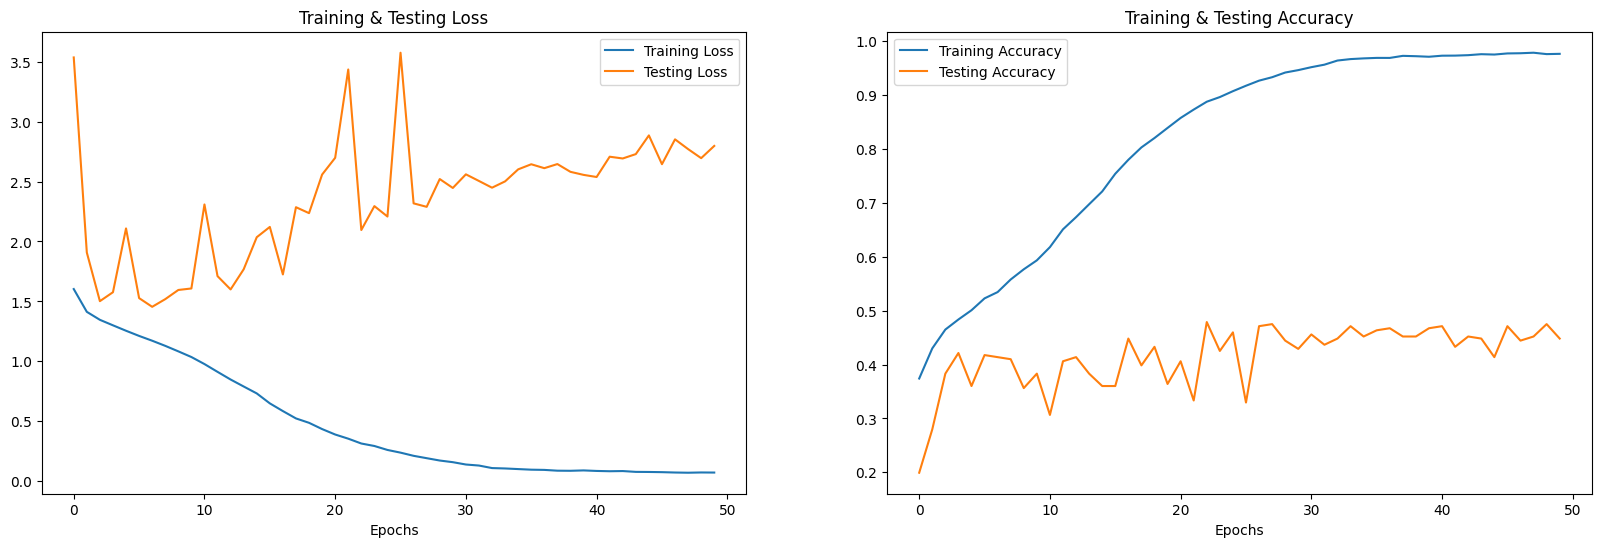

70/70 [==============================] - 1s 9ms/step
0.49395432154052843
              precision    recall  f1-score   support

           0       0.63      0.72      0.67       389
           1       0.47      0.46      0.46       365
           2       0.37      0.32      0.34       373
           3       0.42      0.45      0.43       368
           4       0.59      0.51      0.55       354
           5       0.47      0.50      0.49       384

    accuracy                           0.49      2233
   macro avg       0.49      0.49      0.49      2233
weighted avg       0.49      0.49      0.49      2233



In [ ]:
model = Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))
model.add(Dropout(0.25))

model.add(Conv1D(512, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))
model.add(Dropout(0.25))

model.add(Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))
model.add(Dropout(0.25))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))
model.add(Dropout(0.25))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=3, strides=2, padding="same"))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6, activation="softmax"))

lr_schedule = PolynomialDecay(initial_learning_rate=0.001, decay_steps=10000, end_learning_rate=0.0001, power=0.5)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["acc", f1_m])

# Define the checkpoint file path
checkpoint_filepath = 'best_model_kaggle.h5'

# Define the ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_f1_m',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_callback]
)

# Load the best model based on validation accuracy
model.load_weights(checkpoint_filepath)

# Evaluate the model on the test set
test_loss, test_acc, test_f1 = model.evaluate(x_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_acc)
print("Test F1-score:", test_f1)


print("Accuracy on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


model.evaluate(test_dataset)
predA = np.argmax(model.predict(x_test), axis=-1)
y_testc = np.argmax(y_test, axis=-1)

print(accuracy_score(y_testc, predA))
print(classification_report(y_testc, predA))

70/70 [==============================] - 1s 9ms/step


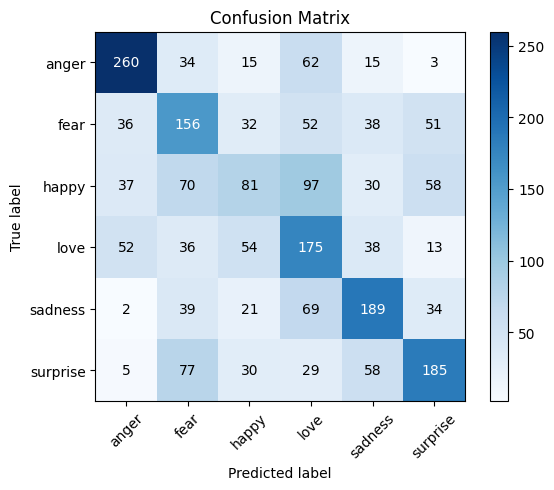

In [ ]:
import scikitplot as skplt

class_names = ['anger', 'fear', 'happy', 'love', 'sadness', 'surprise']
predA = np.argmax(model.predict(x_test), axis=-1)
y_testc = np.argmax(y_test, axis=-1)
skplt.metrics.plot_confusion_matrix(y_testc, predA)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_testc, predA)
confusion_rates = np.sum(cm - np.eye(cm.shape[0]) * cm, axis=1) / np.sum(cm, axis=1)

# Print the confusion rates for each class
print(confusion_rates)

[0.33161954 0.57260274 0.78284182 0.52445652 0.46610169 0.51822917]


# 2D Modelling

In [ ]:
x_features = []
y_labels = []

In [ ]:
for wav in tqdm(os.listdir(crema_path)):
    wav_name = wav.partition(".wav")[0].split("_")
    x_features.append(crema_path+'/'+wav)
    y_labels.append(emotion_dict[wav_name[2]])

100%|██████████| 7442/7442 [00:00<00:00, 470955.83it/s]


In [ ]:
data = {
    'file_path' : x_features,
    'emotion' : y_labels
}
df = pd.DataFrame(data)
df.head()

,file_path,emotion
0,../input/speech-emotion-recognition-en/Crema/1...,disgust
1,../input/speech-emotion-recognition-en/Crema/1...,happy
2,../input/speech-emotion-recognition-en/Crema/1...,happy
3,../input/speech-emotion-recognition-en/Crema/1...,disgust
4,../input/speech-emotion-recognition-en/Crema/1...,disgust


In [ ]:
def display_load_audio(wav_path):
    waves, sr = librosa.load(wav_path)
    plt.figure(figsize=(15,6))
    librosa.display.waveshow(waves, color='green')
    
    IPython.display.display(IPython.display.Audio(wav_path))
    print("==============================================")

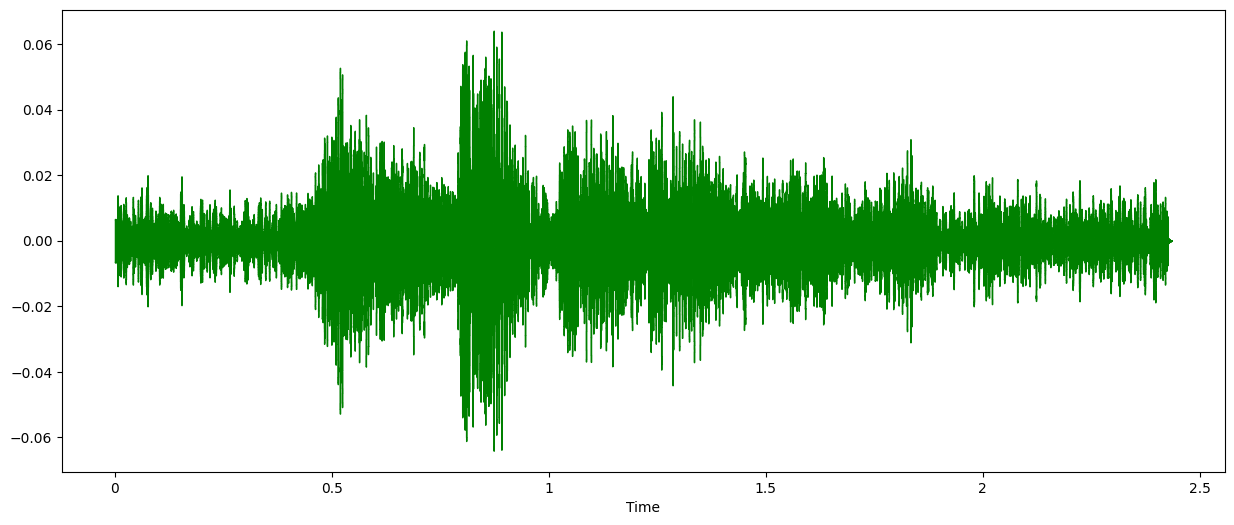

In [ ]:
display_load_audio(df['file_path'][0])

In [ ]:
df['emotion'].unique()

array(['disgust', 'happy', 'sad', 'neutral', 'fear', 'angry'],
      dtype=object)

Emotion : disgust


Emotion : happy


Emotion : sad


Emotion : neutral


Emotion : fear


Emotion : angry


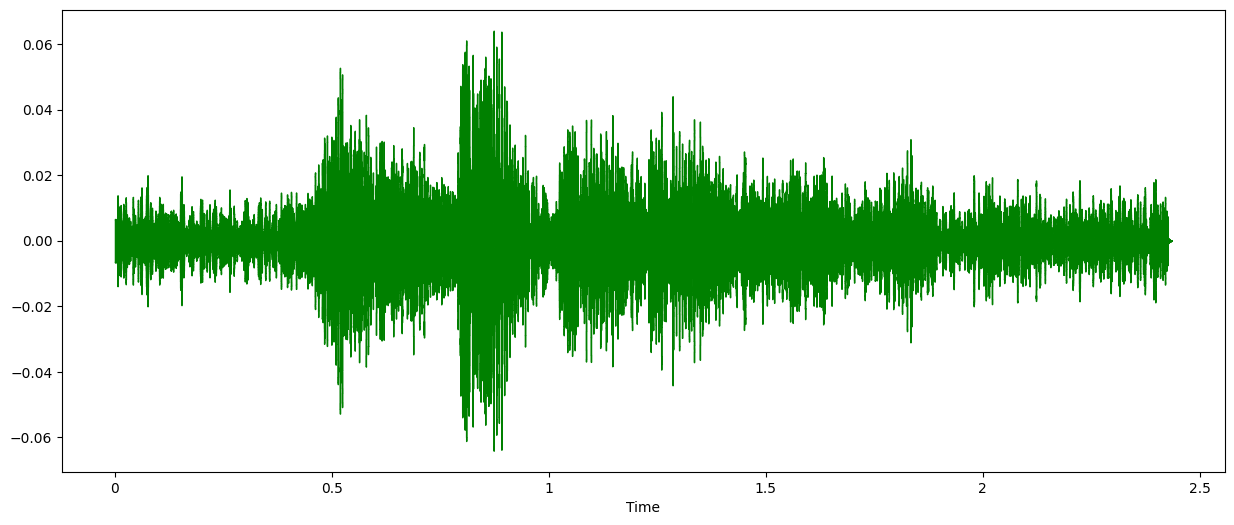

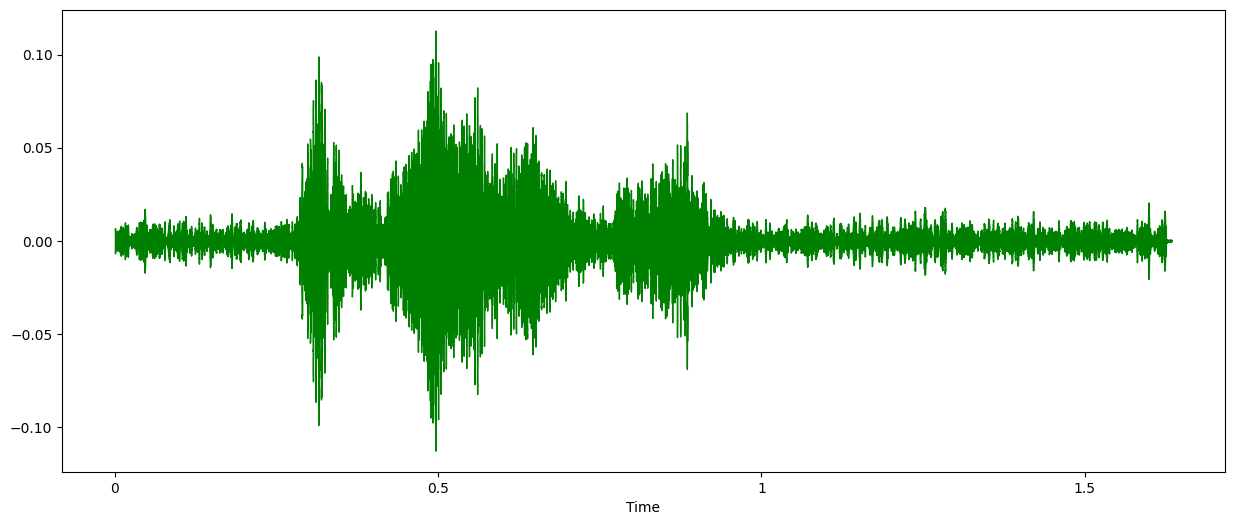

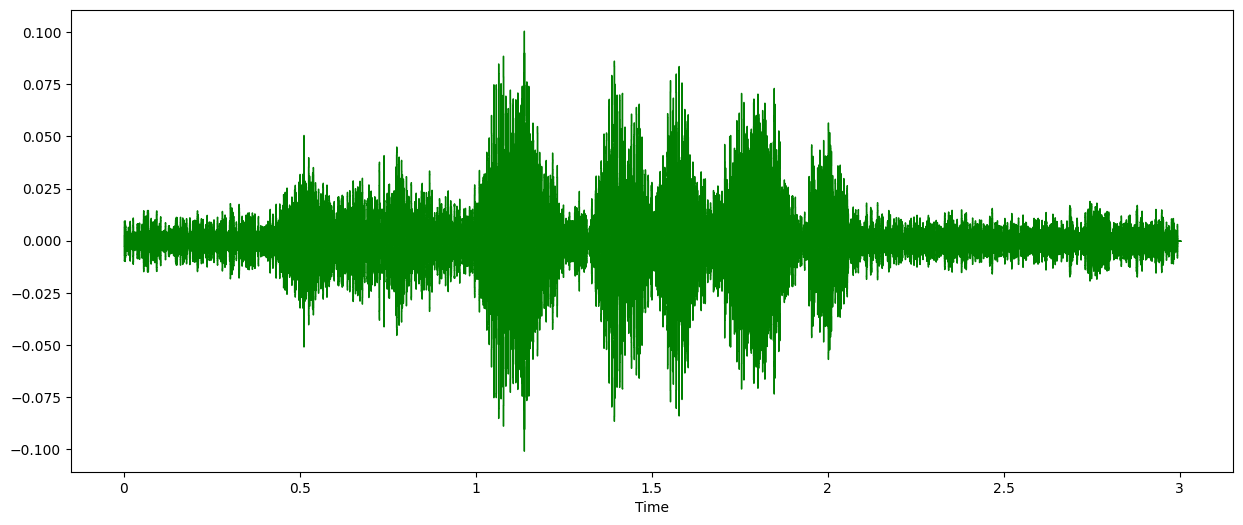

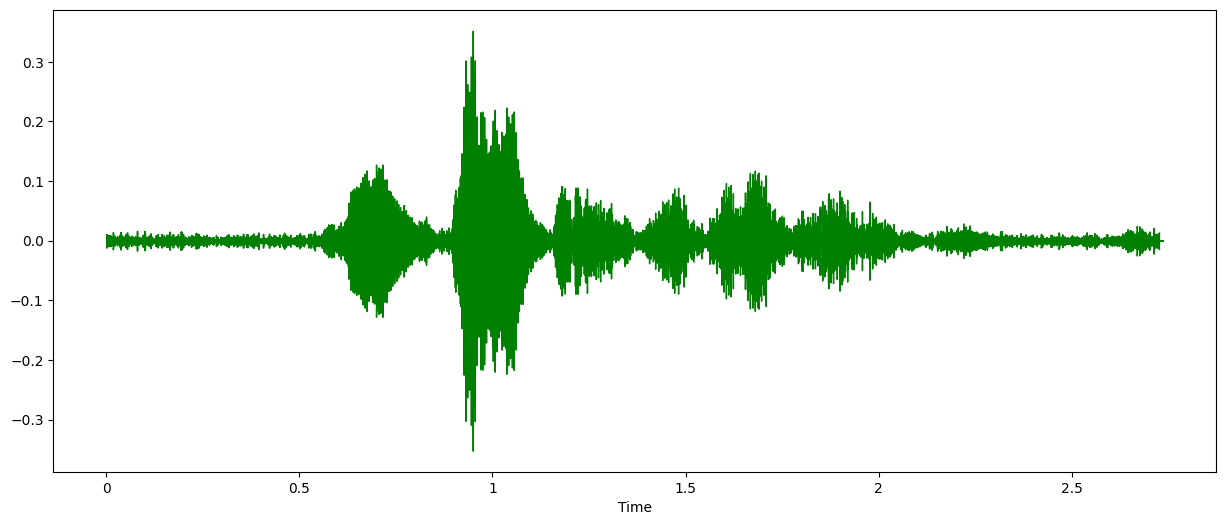

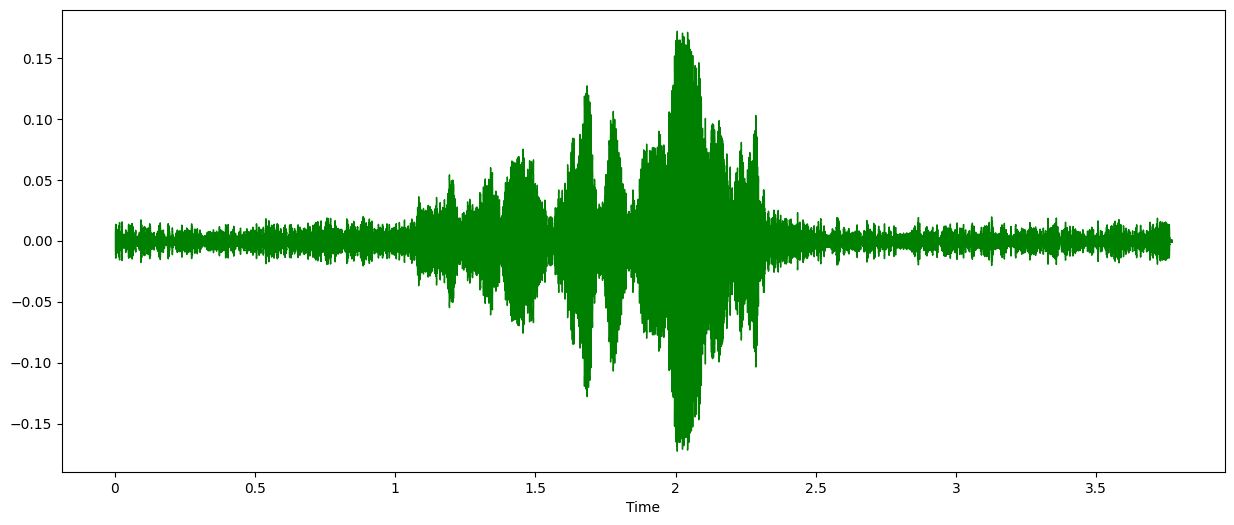

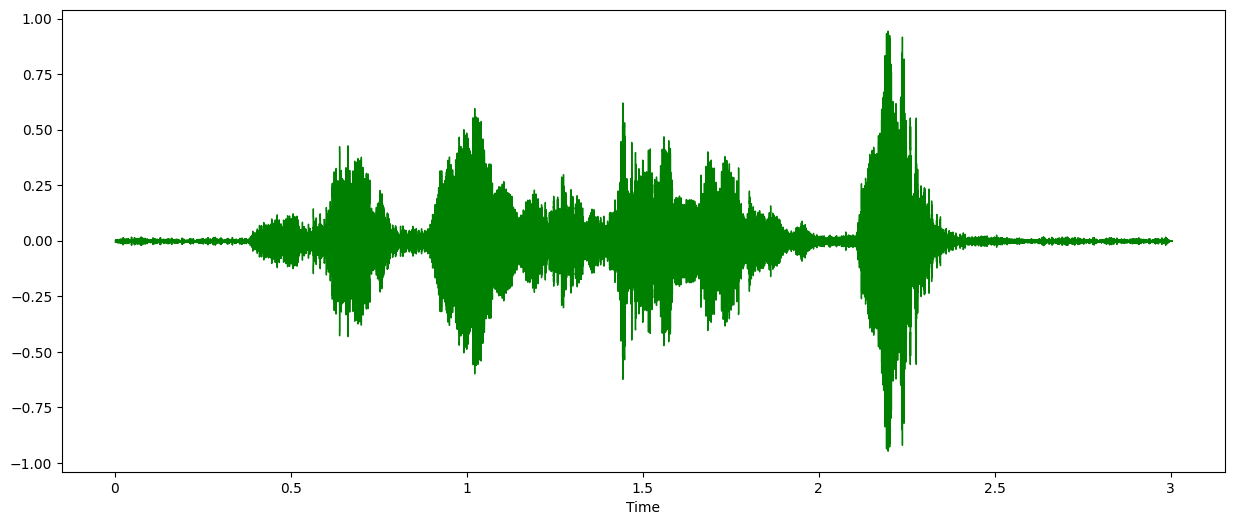

In [ ]:
for emotion in df['emotion'].unique():
    print("Emotion :",emotion)
    display_load_audio(df.loc[df['emotion'] == emotion]['file_path'].iloc[0])

# SPLIT First

In [ ]:
def preprocess_data(feat2D, labels, le, test_size =0.3, val_size=0.05, random_state=32):
    labels = le.fit_transform(labels)
    feat2D, labels = shuffle(feat2D, labels, random_state=random_state)
    labels = to_categorical(labels, len(np.unique(labels)))
    x_train, x_test, y_train, y_test = train_test_split(feat2D, labels, test_size=test_size, random_state=random_state)
    x_train, x_val , y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=random_state)
    
    del feat2D
    del labels
    gc.collect()
    
    x_train = np.array(x_train) 
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    x_val = np.array(x_val)
    y_val = np.array(y_val)
    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    print(x_val.shape)
    print(y_val.shape)
    
    return x_train, x_val , y_train, y_val, x_test, y_test, le

In [ ]:
le = LabelEncoder()
x_train, x_val , y_train, y_val, x_test, y_test, le = preprocess_data(df['file_path'], df['emotion'], le) 

(4948,)
(4948, 6)
(2233,)
(2233, 6)
(261,)
(261, 6)


In [ ]:
def load_data(x_test, n_mels=128):
    res = []
    for i in tqdm(x_test):
        d, sr = librosa.load(i)
        mel_spec = librosa.feature.melspectrogram(y=d, sr=sr, n_mels=n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        res.append(log_mel_spec)

    return res

x_test = load_data(x_test)
x_val = load_data(x_val)

100%|██████████| 261/261 [00:07<00:00, 33.40it/s]


In [ ]:
data = []
sr_array = []
emotions = []

for i in tqdm(range(4600)):
    d, sr = librosa.load(x_train[i])
    noised_data = add_noise(d, random=True)
    shifted_data = shift(d)
    data.extend([d, noised_data, shifted_data])
    emotions.extend([y_train[i]]*3)
    sr_array.extend([sr])
data = np.array(data)
emotions = np.array(emotions) 
sr_array = np.array(sr_array)
print(data.shape)
print(data[0].shape)

100%|██████████| 4600/4600 [01:05<00:00, 70.09it/s]

(13800,)
(60331,)



/tmp/ipykernel_31/4016870345.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [ ]:
emotions[7]

array([0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
sr_array.shape

(4600,)

In [ ]:
del df

gc.collect()

30217

## Create the Feature Space (mel spectrum)

In [ ]:
y, sr = librosa.load(df['file_path'][0])
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
print(log_mel_spec.shape)

In [ ]:
def get_2D_features(data, sr, n_mels=128):
    features_2D=[]
    j=-1
    for i in tqdm(range(len(data))):
        if i%3 == 0:
            j+=1
        mel_spec = librosa.feature.melspectrogram(y=data[i], sr=sr[j], n_mels=n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        features_2D.append(log_mel_spec)
        

    return features_2D

In [ ]:
data = np.array(data)
data[0]

array([ 3.4364257e-03,  4.1149287e-03,  3.8781739e-03, ...,
       -1.7151631e-06,  1.7043544e-06,  0.0000000e+00], dtype=float32)

In [ ]:
features_2D = get_2D_features(data, sr_array)

100%|██████████| 13800/13800 [03:02<00:00, 75.47it/s]


In [ ]:
del data

In [ ]:
gc.collect()

0

In [ ]:
data_2D = {
    'feat2D' : features_2D,
    'emotion' : emotions
}
df2D = pd.DataFrame(data_2D)
df2D.head()

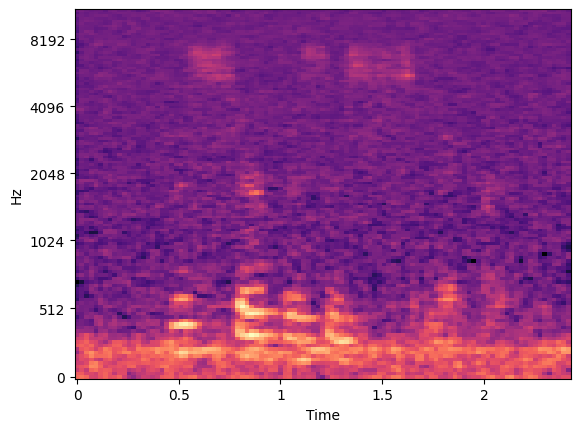

In [ ]:
librosa.display.specshow(df2D['feat2D'][1],  x_axis='time', y_axis='mel')

#### preprocess data

In [ ]:
def fix_size(feat2D, size):
    #result = []
    for i in tqdm(range(len(feat2D))):
        feat2D[i] = np.expand_dims(cv2.resize(feat2D[i], size), -1)
    feat2D = np.array(feat2D)
    print(feat2D.shape)
    #result = np.array(result)
    #return result

In [ ]:
fix_size(features_2D, tuple((128,128)))
fix_size(x_test, tuple((128,128)))
fix_size(x_val, tuple((128,128)))

100%|██████████| 13800/13800 [00:00<00:00, 20637.63it/s]


(13800, 128, 128, 1)


100%|██████████| 2233/2233 [00:00<00:00, 28459.85it/s]


(2233, 128, 128, 1)


100%|██████████| 261/261 [00:00<00:00, 21709.30it/s]

(261, 128, 128, 1)


In [ ]:
features_2D = np.array(features_2D)
print(features_2D.shape)

(13800, 128, 128, 1)


In [ ]:
len(np.unique(y_train))

2

In [ ]:
y_train[17]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(256, kernel_size=(5,5), strides=1, padding="same", input_shape=(128,128,1), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(5,5), strides=2, padding="same"))

    model.add(Conv2D(256, kernel_size=(5,5), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(5,5), strides=2, padding="same"))

    model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(5,5), strides=2, padding="same"))

    model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3,3), strides=2, padding="same"))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(6, activation="softmax"))
    model.summary()
    return model

In [ ]:
def train(model, x_train, y_train, x_val, y_val, epochs_num,optimizer, callback, accuracy, val_accuracy, loss, val_loss):
    model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])
    hist = model.fit(x_train, y_train, epochs=epochs_num, batch_size=64, validation_data=(x_val,y_val), 
                    callbacks=[callback])
    scores = pd.DataFrame(model.history.history)
    
    accuracy.append(scores[['accuracy']])
    val_accuracy.append(scores[['val_accuracy']])
    loss.append(scores[['loss']])
    val_loss.append(scores[['val_loss']])

In [ ]:
checkpoint_path = '../kaggle/working/checkpoint/model_weights.ckpt'

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

In [ ]:
def lr_scheduler(epoch, lr):
    if epoch%10 == 0:
        return lr/10
    return lr

In [ ]:
model = build_model()
callback = LearningRateScheduler(lr_scheduler)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     6656      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 256)    1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       1638656   
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
accuracy = []
val_accuracy = []
loss = []
val_loss = []

In [ ]:
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
print(features_2D.shape)
print(emotions.shape)
print(x_val.shape)
print(y_val.shape)

(13800, 128, 128, 1)
(13800, 6)
(261, 128, 128, 1)
(261, 6)


In [ ]:
optimizer=Adam(lr=0.0001)
train(model, features_2D, emotions, x_val, y_val, 10, optimizer, checkpoint_callback, accuracy, val_accuracy, loss, val_loss)

Epoch 1/10
216/216 [==============================] - 38s 161ms/step - loss: 0.1028 - accuracy: 0.9646 - val_loss: 3.0981 - val_accuracy: 0.5364
Epoch 2/10
216/216 [==============================] - 35s 160ms/step - loss: 0.1009 - accuracy: 0.9641 - val_loss: 2.3426 - val_accuracy: 0.5632
Epoch 3/10
216/216 [==============================] - 35s 160ms/step - loss: 0.0712 - accuracy: 0.9763 - val_loss: 2.1777 - val_accuracy: 0.5709
Epoch 4/10
216/216 [==============================] - 35s 160ms/step - loss: 0.0579 - accuracy: 0.9798 - val_loss: 2.5219 - val_accuracy: 0.6015
Epoch 5/10
216/216 [==============================] - 35s 160ms/step - loss: 0.0518 - accuracy: 0.9823 - val_loss: 2.3442 - val_accuracy: 0.5939
Epoch 6/10
216/216 [==============================] - 34s 160ms/step - loss: 0.0848 - accuracy: 0.9677 - val_loss: 2.3907 - val_accuracy: 0.5326
Epoch 7/10
216/216 [==============================] - 35s 161ms/step - loss: 0.0393 - accuracy: 0.9876 - val_loss: 2.1900 - val_ac

In [ ]:
def plot_scores(accuracy, val_accuracy, loss, val_loss):
    titles = ["accuracy vs val_accuracy", "loss vs val_loss"]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,6))
    
    for i in range(2):
        fig.add_subplot(1,2,i+1)
        axes[i].set_title(titles[i])
        if i==0 : 
            plt.plot(accuracy)
            plt.plot(val_accuracy)
        if i==1 : 
            plt.plot(loss)
            plt.plot(val_loss)
            

In [ ]:
loss[0]['loss'].values

array([1.39473581, 1.16020107, 1.05482781, 0.96474957, 0.89311743,
       0.79111207, 0.70275497, 0.61935121, 0.52337039, 0.42264214])

In [ ]:
def process_score(accuracy, val_accuracy, loss, val_loss):
    p_accuracy = []
    p_val_accuracy = []
    p_loss = []
    p_val_loss = []
    for i in range(len(accuracy)):
        p_accuracy.extend(accuracy[i]['accuracy'].values)
        p_val_accuracy.extend(val_accuracy[i]['val_accuracy'].values)
        p_loss.extend(loss[i]['loss'].values)
        p_val_loss.extend(val_loss[i]['val_loss'].values)
        
    return p_accuracy, p_val_accuracy, p_loss, p_val_loss

In [ ]:
p_accuracy, p_val_accuracy, p_loss, p_val_loss = process_score(accuracy, val_accuracy, loss, val_loss)

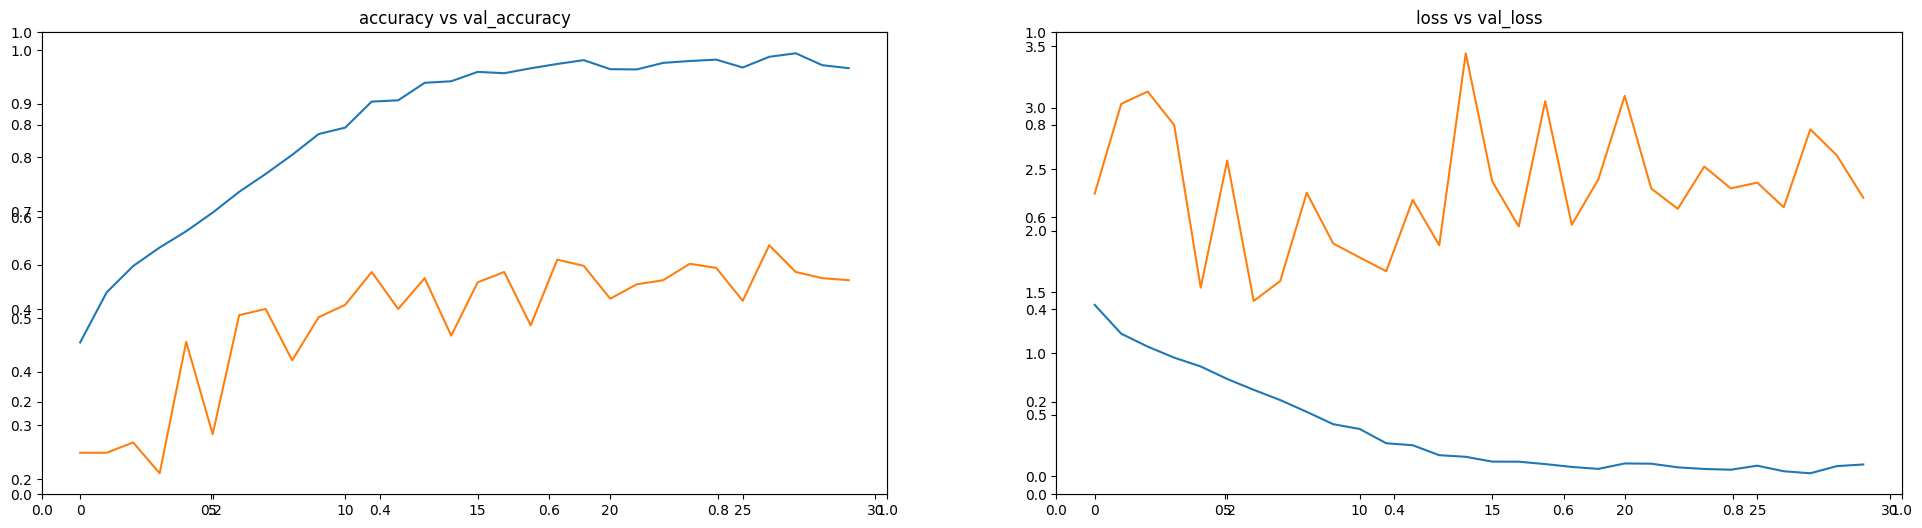

In [ ]:
plot_scores(p_accuracy, p_val_accuracy, p_loss, p_val_loss)

In [ ]:
model.load_weights(checkpoint_path)

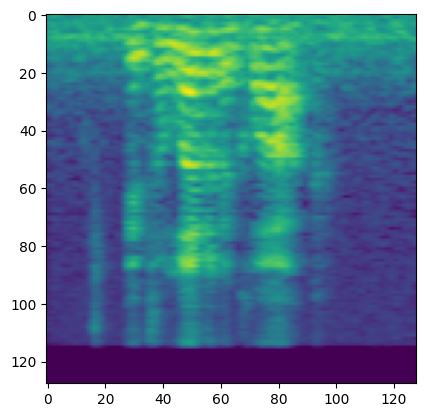

In [ ]:
plt.imshow(x_test[0])

In [ ]:
x_test[0]
x_test = np.array(x_test)
print(x_test.shape)
print(y_test.shape)

(2233, 128, 128, 1)
(2233, 6)


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size=64)
model.evaluate(test_dataset)

35/35 [==============================] - 2s 55ms/step - loss: 2.2298 - accuracy: 0.6064


[2.2297518253326416, 0.6063591837882996]

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size=64)
model.evaluate(val_dataset)

5/5 [==============================] - 0s 48ms/step - loss: 2.1900 - accuracy: 0.6360


[2.1899755001068115, 0.6360152959823608]

In [ ]:
predA = np.argmax(model.predict(x_test), axis=-1)
y_testc = np.argmax(y_test, axis=-1)

print(len(x_test))
print(len(y_test))
print(accuracy_score(y_testc, predA))
print(classification_report(y_testc, predA))

70/70 [==============================] - 2s 26ms/step
2233
2233
0.606359158083296
              precision    recall  f1-score   support

           0       0.75      0.72      0.74       390
           1       0.59      0.55      0.57       371
           2       0.50      0.55      0.53       386
           3       0.62      0.62      0.62       378
           4       0.60      0.74      0.67       328
           5       0.58      0.47      0.52       380

    accuracy                           0.61      2233
   macro avg       0.61      0.61      0.61      2233
weighted avg       0.61      0.61      0.60      2233



### Confusion Matrix

In [ ]:
class_names = ['anger', 'fear', 'happy', 'love', 'sadness', 'surprise']

9/9 [==============================] - 0s 26ms/step


([<matplotlib.axis.YTick at 0x7b3c0c739030>,
 [Text(0, 0, 'anger'),
  Text(0, 1, 'fear'),
  Text(0, 2, 'happy'),
  Text(0, 3, 'love'),
  Text(0, 4, 'sadness'),
  Text(0, 5, 'surprise')])

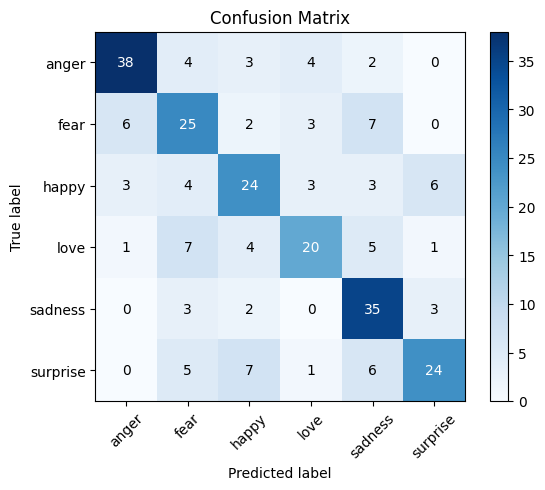

In [ ]:
pred_valA = np.argmax(model.predict(x_val), axis=-1)
y_valc = np.argmax(y_val, axis=-1)
skplt.metrics.plot_confusion_matrix(y_valc, pred_valA)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

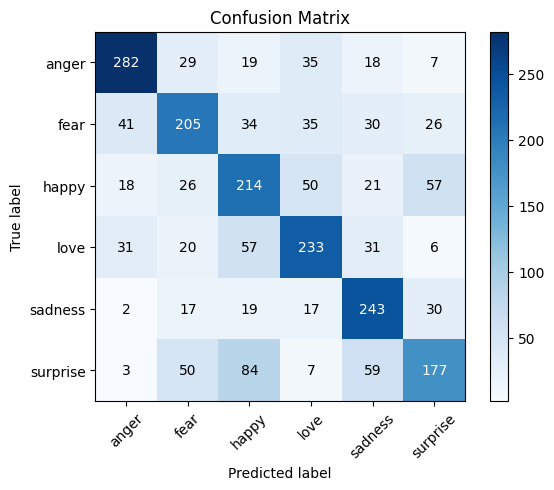

In [ ]:
skplt.metrics.plot_confusion_matrix(y_testc, predA)#, class_names=class_names)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

# Show the modified plot
plt.show()

## Most confusing classes

In [ ]:
cm = confusion_matrix(y_testc, predA)
sum_row = np.sum(cm, axis=1)

conf_score = []
for i in range(sum_row.shape[0]):
    per = (sum_row[i]-cm[i,i])/(sum_row[i])
    conf_score.append(per)
  

conf_dic = {}
for i in range(len(class_names)):
    conf_dic[class_names[i]] = str(round(conf_score[i], 2) * 100) +" %" 

conf_dic

{'anger': '28.000000000000004 %',
 'fear': '45.0 %',
 'happy': '45.0 %',
 'love': '38.0 %',
 'sadness': '26.0 %',
 'surprise': '53.0 %'}

### F1 score And Accuracy

In [ ]:
# test data
f1 = f1_score(y_testc, predA, average="weighted")
acc = accuracy_score(y_testc, predA)
print("F1 score of model ", f1)
print("accuracy socre of model ", acc)

F1 score of model  0.6047784349971981
accuracy socre of model  0.606359158083296


# #

In [ ]:
x_features = []
y_labels = []

In [ ]:
for wav in tqdm(os.listdir(crema_path)):
    wav_name = wav.partition(".wav")[0].split("_")
    x_features.append(crema_path+'/'+wav)
    y_labels.append(emotion_dict[wav_name[2]])

100%|██████████| 7442/7442 [00:00<00:00, 507792.59it/s]


In [ ]:
data = {
    'file_path' : x_features,
    'emotion' : y_labels
}
df = pd.DataFrame(data)
df.head()

,file_path,emotion
0,../input/speech-emotion-recognition-en/Crema/1...,disgust
1,../input/speech-emotion-recognition-en/Crema/1...,happy
2,../input/speech-emotion-recognition-en/Crema/1...,happy
3,../input/speech-emotion-recognition-en/Crema/1...,disgust
4,../input/speech-emotion-recognition-en/Crema/1...,disgust


In [ ]:
data = []
sr_array = []
emotions = []
df['file_path'], df['emotion'] = shuffle(df['file_path'], df['emotion'], random_state=32)

for i in tqdm(range(4700)):
    d, sr = librosa.load(df['file_path'][i])
    noised_data = add_noise(d, random=True)
    #pitched_data = pitch(d, sr, random=True)
    shifted_data = shift(d)
    #stretched_data = stretch(d)
    data.extend([d, noised_data, shifted_data])#, pitched_data, stretched_data])
    emotions.extend([df['emotion'][i]]*3)
    sr_array.extend([sr])
data = np.array(data)
emotions = np.array(emotions) 
sr_array = np.array(sr_array)
print(data.shape)
print(data[0].shape)

100%|██████████| 4700/4700 [01:06<00:00, 70.80it/s]

(14100,)
(53709,)



/tmp/ipykernel_31/1350525083.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [ ]:
del df

gc.collect()

138656

## Create the Feature Space (mel spectrum)

In [ ]:
y, sr = librosa.load(df['file_path'][0])
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
print(log_mel_spec.shape)

In [ ]:
def get_2D_features(data, sr, n_mels=128):
    features_2D=[]
    j=-1
    for i in tqdm(range(len(data))):
        if i%3 == 0:
            j+=1
        mel_spec = librosa.feature.melspectrogram(y=data[i], sr=sr[j], n_mels=n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        features_2D.append(log_mel_spec)
        

    return features_2D

In [ ]:
data = np.array(data)
data[0]

array([ 5.1987115e-03,  6.5078777e-03,  6.3527757e-03, ...,
        2.6242395e-07, -3.5741661e-07,  0.0000000e+00], dtype=float32)

In [ ]:
features_2D = get_2D_features(data, sr_array)

100%|██████████| 14100/14100 [03:04<00:00, 76.57it/s]


In [ ]:
del data

In [ ]:
gc.collect()

30226

In [ ]:
data_2D = {
    'feat2D' : features_2D,
    'emotion' : emotions#df['emotion']
}
df2D = pd.DataFrame(data_2D)
df2D.head()

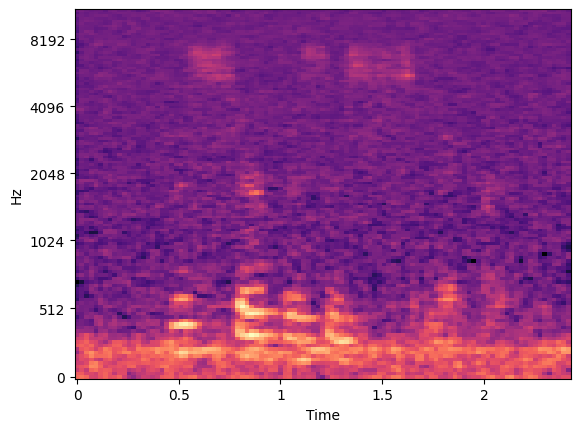

In [ ]:
librosa.display.specshow(df2D['feat2D'][1],  x_axis='time', y_axis='mel')

### 2D Modelling

#### preprocess data

In [ ]:
def fix_size(feat2D, size):
    #result = []
    for i in tqdm(range(len(feat2D))):
        feat2D[i] = np.expand_dims(cv2.resize(feat2D[i], size), -1)
    feat2D = np.array(feat2D)
    print(feat2D.shape)
    #result = np.array(result)
    #return result

In [ ]:
def preprocess_data(feat2D, labels, le, test_size =0.3, val_size=0.05, random_state=32):
    labels = le.fit_transform(labels)
    feat2D, labels = shuffle(feat2D, labels, random_state=random_state)
    labels = to_categorical(labels, len(np.unique(labels)))
    x_train, x_test, y_train, y_test = train_test_split(feat2D, labels, test_size=test_size, random_state=random_state)
    x_train, x_val , y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=random_state)
    
    del feat2D
    del labels
    gc.collect()
    
    x_train = np.array(x_train) 
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    x_val = np.array(x_val)
    y_val = np.array(y_val)
    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    print(x_val.shape)
    print(y_val.shape)
    
    return x_train, x_val , y_train, y_val, x_test, y_test, le

In [ ]:
fix_size(features_2D, tuple((128,128)))

100%|██████████| 14100/14100 [00:00<00:00, 24732.00it/s]


(14100, 128, 128, 1)


In [ ]:
features_2D = np.array(features_2D)
print(features_2D.shape)

(14100, 128, 128, 1)


In [ ]:
le = LabelEncoder()
x_train, x_val , y_train, y_val, x_test, y_test, le = preprocess_data(features_2D, emotions, le) 
del features_2D
del emotions
gc.collect

(9376, 128, 128, 1)
(9376, 6)
(4230, 128, 128, 1)
(4230, 6)
(494, 128, 128, 1)
(494, 6)


<function gc.collect(generation=2)>

In [ ]:
len(np.unique(y_train))

2

In [ ]:
y_train[17]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(256, kernel_size=(5,5), strides=1, padding="same", input_shape=(128,128,1), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(5,5), strides=2, padding="same"))

    model.add(Conv2D(256, kernel_size=(5,5), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(5,5), strides=2, padding="same"))

    model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(5,5), strides=2, padding="same"))

    model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3,3), strides=2, padding="same"))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(6, activation="softmax"))
    model.summary()
    return model

In [ ]:
def train(model, epochs_num,optimizer, callback, accuracy, val_accuracy, loss, val_loss):
    model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])
    hist = model.fit(x_train, y_train, epochs=epochs_num, batch_size=64, validation_data=(x_val,y_val), 
                    callbacks=[callback])
    scores = pd.DataFrame(model.history.history)
    
    accuracy.append(scores[['accuracy']])
    val_accuracy.append(scores[['val_accuracy']])
    loss.append(scores[['loss']])
    val_loss.append(scores[['val_loss']])

In [ ]:
checkpoint_path = '../kaggle/working/checkpoint/model_weights.ckpt'

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

In [ ]:
def lr_scheduler(epoch, lr):
    if epoch%10 == 0:
        return lr/10
    return lr

In [ ]:
model = build_model()
callback = LearningRateScheduler(lr_scheduler)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 128, 128, 256)     6656      
                                                                 
 batch_normalization_42 (Bat  (None, 128, 128, 256)    1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 64, 64, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 256)       1638656   
                                                                 
 batch_normalization_43 (Bat  (None, 64, 64, 256)      1024      
 chNormalization)                                                
                                                     

In [ ]:
accuracy = []
val_accuracy = []
loss = []
val_loss = []

In [ ]:
optimizer=Adam(lr=0.0001)
train(model, 10, optimizer, checkpoint_callback, accuracy, val_accuracy, loss, val_loss)

Epoch 1/10
147/147 [==============================] - 27s 163ms/step - loss: 0.0891 - accuracy: 0.9707 - val_loss: 0.9081 - val_accuracy: 0.7632
Epoch 2/10
147/147 [==============================] - 24s 161ms/step - loss: 0.0589 - accuracy: 0.9793 - val_loss: 0.9694 - val_accuracy: 0.7449
Epoch 3/10
147/147 [==============================] - 24s 161ms/step - loss: 0.0584 - accuracy: 0.9806 - val_loss: 1.3514 - val_accuracy: 0.6761
Epoch 4/10
147/147 [==============================] - 24s 163ms/step - loss: 0.0435 - accuracy: 0.9859 - val_loss: 1.7425 - val_accuracy: 0.5891
Epoch 5/10
147/147 [==============================] - 24s 162ms/step - loss: 0.0756 - accuracy: 0.9733 - val_loss: 0.8976 - val_accuracy: 0.7530
Epoch 6/10
147/147 [==============================] - 24s 163ms/step - loss: 0.0723 - accuracy: 0.9738 - val_loss: 1.2365 - val_accuracy: 0.7287
Epoch 7/10
147/147 [==============================] - 24s 162ms/step - loss: 0.0644 - accuracy: 0.9786 - val_loss: 1.0372 - val_ac

In [ ]:
def plot_scores(accuracy, val_accuracy, loss, val_loss):
    titles = ["accuracy vs val_accuracy", "loss vs val_loss"]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,6))
    
    for i in range(2):
        fig.add_subplot(1,2,i+1)
        axes[i].set_title(titles[i])
        if i==0 : 
            plt.plot(accuracy)
            plt.plot(val_accuracy)
        if i==1 : 
            plt.plot(loss)
            plt.plot(val_loss)
            

In [ ]:
loss[0]['loss'].values

array([1.46213138, 1.24987173, 1.16096246, 1.08619177, 1.02169561,
       0.9646728 , 0.89205456, 0.82636863, 0.7492438 , 0.68369472])

In [ ]:
def process_score(accuracy, val_accuracy, loss, val_loss):
    p_accuracy = []
    p_val_accuracy = []
    p_loss = []
    p_val_loss = []
    for i in range(len(accuracy)):
        p_accuracy.extend(accuracy[i]['accuracy'].values)
        p_val_accuracy.extend(val_accuracy[i]['val_accuracy'].values)
        p_loss.extend(loss[i]['loss'].values)
        p_val_loss.extend(val_loss[i]['val_loss'].values)
        
    return p_accuracy, p_val_accuracy, p_loss, p_val_loss

In [ ]:
p_accuracy, p_val_accuracy, p_loss, p_val_loss = process_score(accuracy, val_accuracy, loss, val_loss)

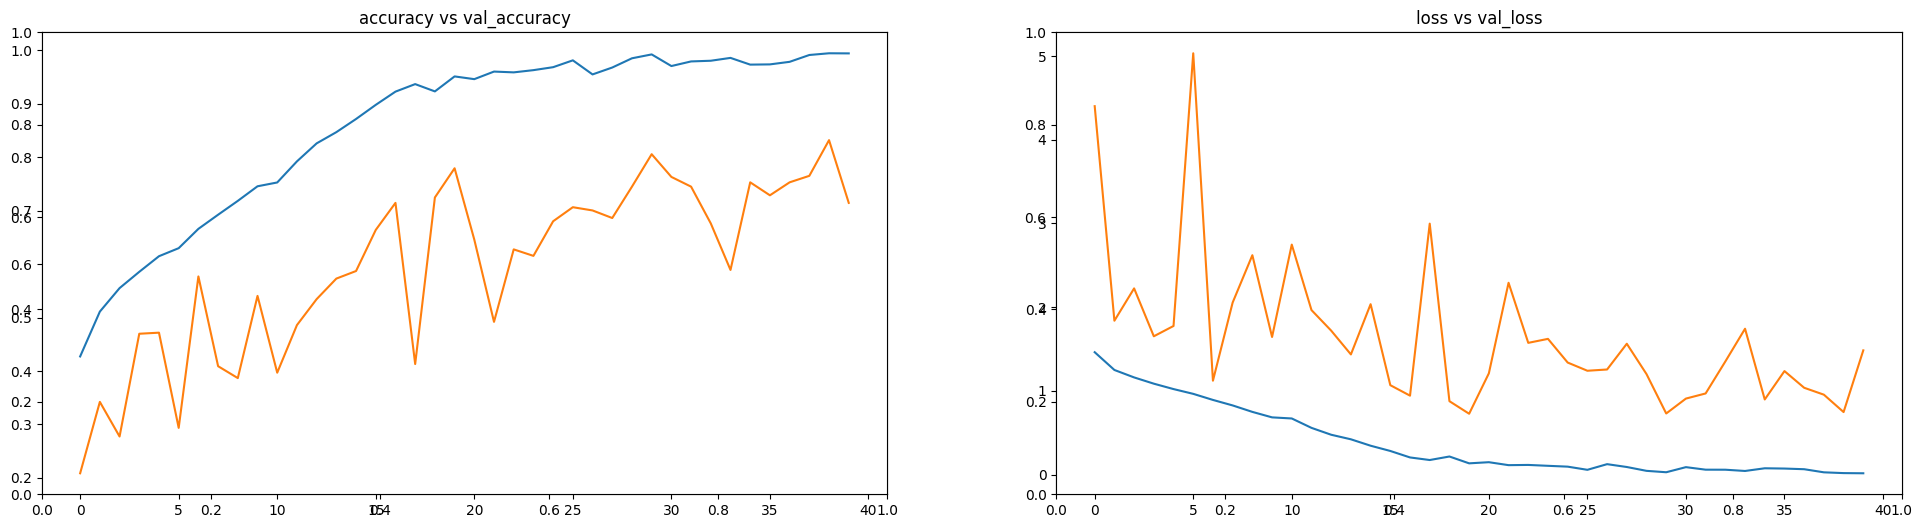

In [ ]:
plot_scores(p_accuracy, p_val_accuracy, p_loss, p_val_loss)

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size=64)
model.evaluate(test_dataset)

67/67 [==============================] - 4s 56ms/step - loss: 0.7586 - accuracy: 0.8388


[0.7585767507553101, 0.8387706875801086]

In [ ]:
predA = np.argmax(model.predict(x_test), axis=-1)
y_testc = np.argmax(y_test, axis=-1)

print(len(x_test))
print(len(y_test))
print(accuracy_score(y_testc, predA))
print(classification_report(y_testc, predA))

133/133 [==============================] - 4s 26ms/step
4230
4230
0.8387706855791962
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       741
           1       0.80      0.85      0.82       718
           2       0.79      0.86      0.82       727
           3       0.89      0.82      0.85       712
           4       0.90      0.79      0.84       588
           5       0.76      0.87      0.81       744

    accuracy                           0.84      4230
   macro avg       0.85      0.84      0.84      4230
weighted avg       0.85      0.84      0.84      4230

